## Install and import libraries

In [1]:
# Install neccessary libraries for dedicated environment
# %pip install pandas matplotlib numpy seaborn scikit-learn tensorflow opencv-python-headless

In [2]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNet, DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Dense, Flatten, Add, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load and preprocess training, test and validation data respectively
#cXrayDir = "/content/drive/MyDrive/Colab Notebooks/CM3070 FYP/chest_xray"
cXrayDir = "chest_xray"
trainDir = os.path.join(cXrayDir,'train')
testDir = os.path.join(cXrayDir,'test')
valDir = os.path.join(cXrayDir,'val')

In [4]:
# # Storing the image data in lists
# xTrain, yTrain, xTest, yTest, xVal, yVal = [], [], [], [], [], []

# # Fill correstponding lists with feature-label pairs in dataset
# for feature, label in train:
#     xTrain.append(feature)
#     yTrain.append(label)
# for feature, label in test:
#     xTest.append(feature)
#     yTest.append(label)
# for feature, label in val:
#     xVal.append(feature)
#     yVal.append(label)

In [5]:
# Labels for classes
labels = ['NORMAL', 'PNEUMONIA']

# Set the desired image size for preprocessing
imageH = 224
imageW = 224

# Function to load Xray image
def loadData(dataDir):
    data = []
    for label in labels:
        path = os.path.join(dataDir, label)

        # Setting Normal class as 0 and Pneumonia class as 1
        classNo = labels.index(label)

        # Iterate through the images in the directory
        for imgFileN in os.listdir(path):
            try:
                # Read img in grayscale
                img = cv2.imread(os.path.join(path, imgFileN), cv2.IMREAD_GRAYSCALE)

                # Resize img
                resizedImg = cv2.resize(img,(imageH, imageW))

                # Append the preprocessed img and class number to list
                data.append([resizedImg, classNo])
            except Exception as e:
                print(path+imgFileN)
                print(e)


    # Convert the data list to a numpy array with dtype 'object'
    return np.array(data, dtype='object')

# Custom function to apply grayscale, edge detection, and Gaussian blur
def imgFilt(img,fNo):
    if fNo == 1:
        # Apply Gaussian Blur to the image
        imgFiltered = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 150/10), -4, 128)
    elif fNo == 2:
        # Apply Canny edge detection to the image
        imgFiltered = cv2.Canny(img, 80, 100)
    elif fNo == 3:
        # Convert the image from BGR to RGB color space (if not already)
        imgFiltered = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Define a kernel for the dilation operation
        kernel = np.ones((5, 5), np.uint8)
        # Apply dilation to the image with multiple iterations
        imgFiltered = cv2.dilate(imgFiltered, kernel, iterations=3)
    return imgFiltered

# Function to apply grayscale, edge detection, and Gaussian blur in an image
def imgFilters(img):
    # Apply Gaussian blur
    f1PassedImg = imgFilt(img,1)
    # Apply edge detection
    f2PassedImg = imgFilt(f1PassedImg,2)
    # Apply dilation
    f3PassedImg = imgFilt(f2PassedImg,2)
    return f3PassedImg

# Plot first n images for each label (NORMAL & PNEUMONIA)
# Filter options: 1 - Gaussian Blur, 2 - Edges Overview, 3 - Dilation, 4 - All 3 filters
def plotFiltImg(data, n, filter=0):
    # List for examplary visualisation
    nSample = []
    pSample = []
    for feature, label in data:
        if label == 0 and len(nSample) < n:
            nSample.append(feature)
        elif label == 1 and len(pSample) < n:
            pSample.append(feature)
        else:
            continue
    f, ax = plt.subplots(2, n, figsize=(n*5, 10))
    for i in range(n*2):
        if i < n:
            img = nSample[i%n]
        else:
            img = pSample[i%n]
        if filter != 0:
            if filter == 1:
                img = imgFilt(img,1)
            elif filter == 2:
                img = imgFilt(img,2)
            elif filter == 3:
                img = imgFilt(img,3)
            elif filter == 4:
                img = imgFilters(img)
        if i < n:
            ax[i//n, i%n].imshow(img, cmap='gray')
            ax[i//n, i%n].set_title('NORMAL')
        else:
            ax[i//n, i%n].imshow(img, cmap='gray')
            ax[i//n, i%n].set_title('PNEUMONIA')
        ax[i//n, i%n].axis('off')
        ax[i//n, i%n].set_aspect('auto')
    plt.show()

In [6]:
train = loadData(trainDir)
test = loadData(testDir)
val = loadData(valDir)
print(f"Training Set has: {len(train)} images")
print(f"Testing Set has: {len(test)} images")
print(f"Validation Set has: {len(val)} images")

Training Set has: 5216 images
Testing Set has: 624 images
Validation Set has: 16 images


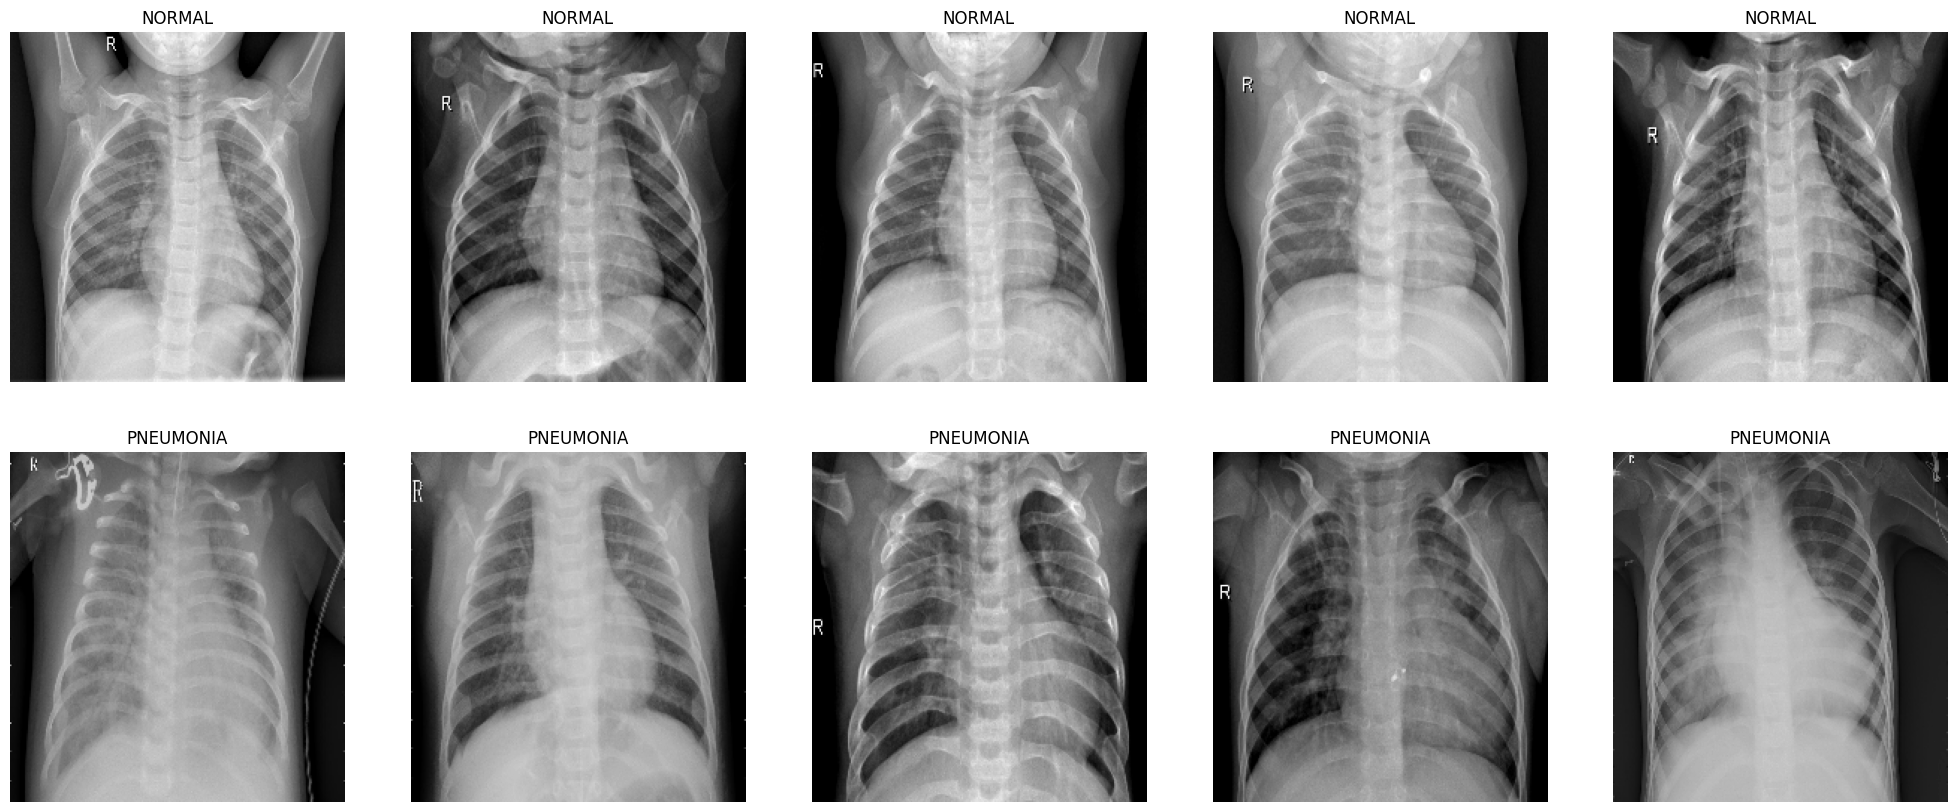

In [7]:
# Unfiltered Overview for train dataset
plotFiltImg(train,5)

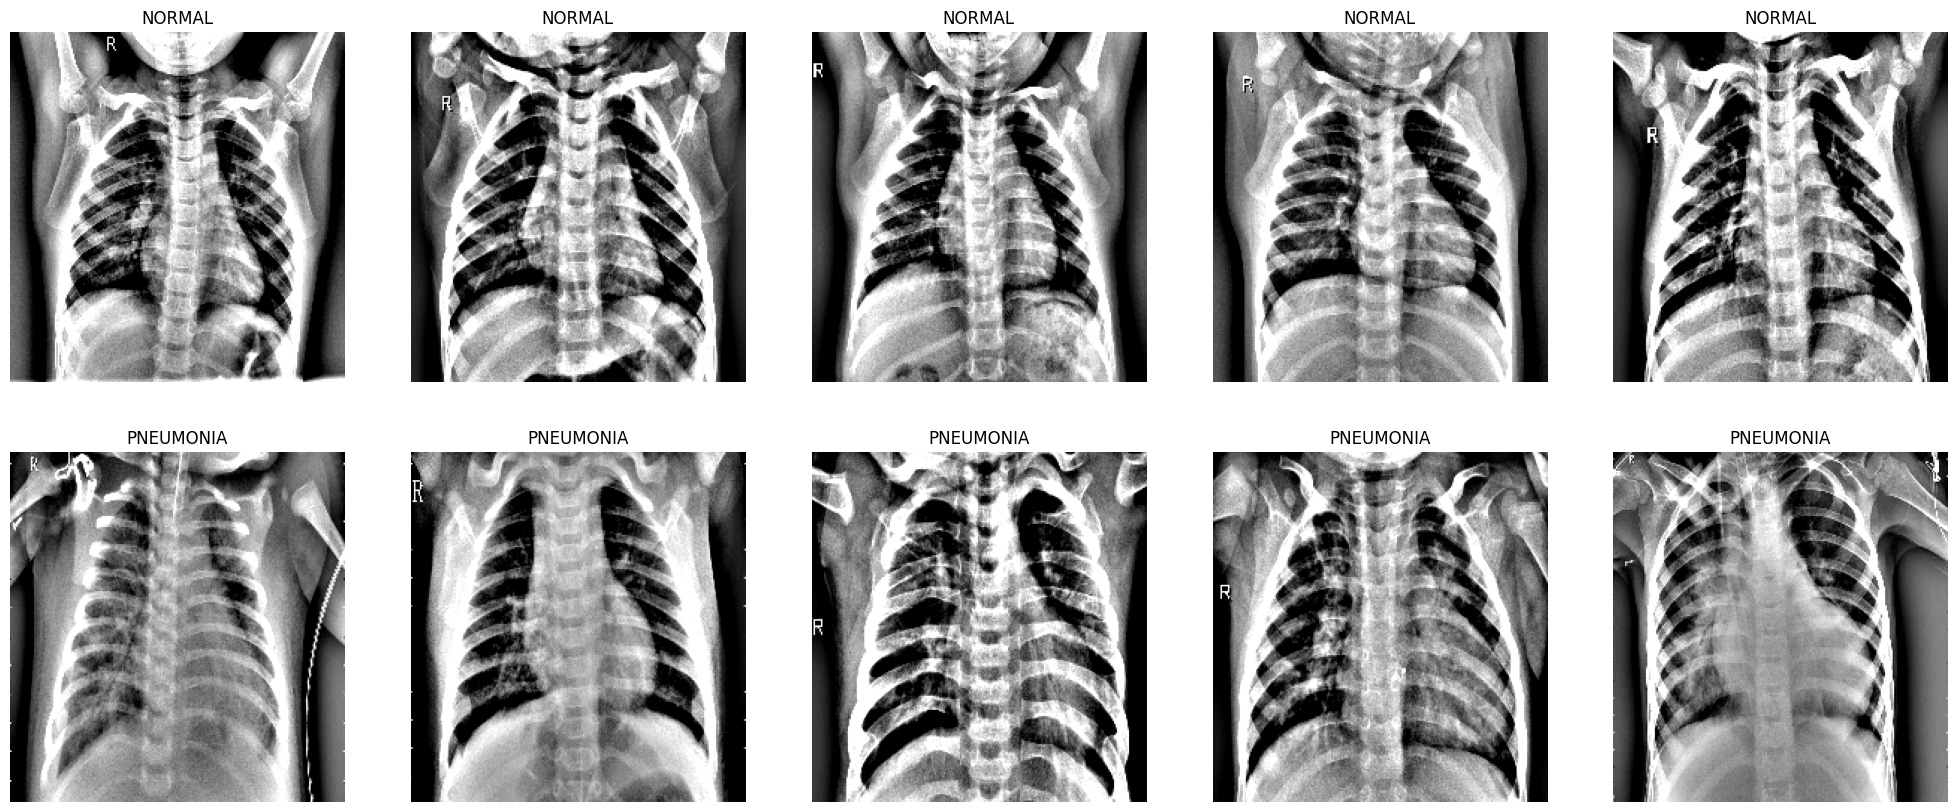

In [8]:
# Gaussian Blur Overview for train dataset
plotFiltImg(train,5,1)

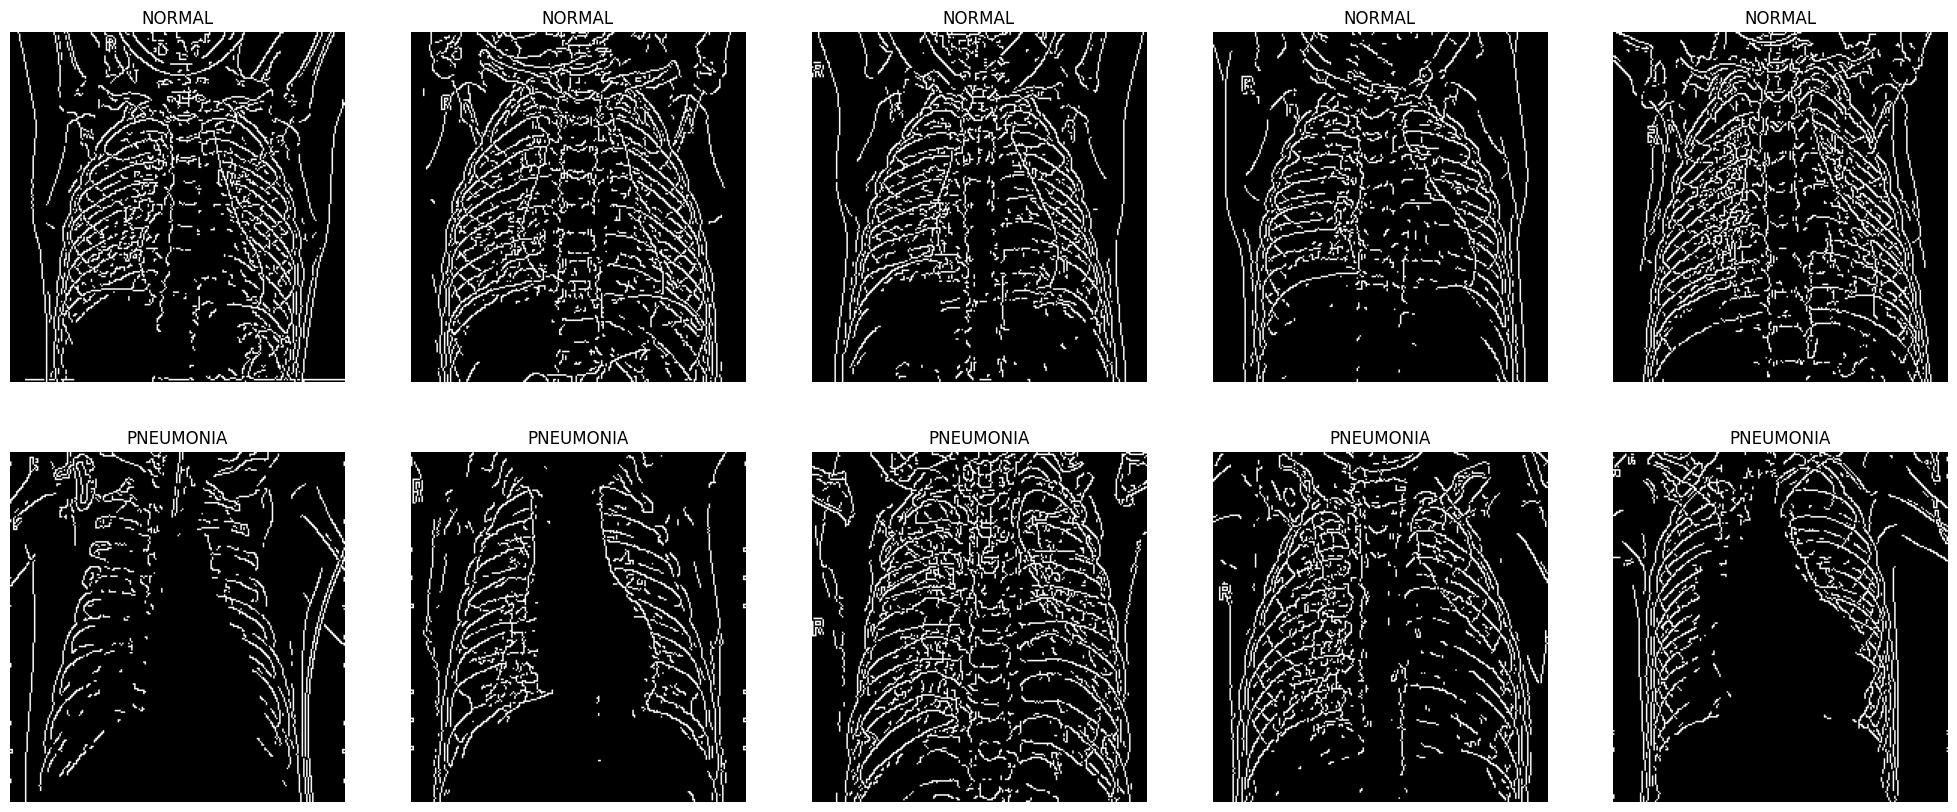

In [9]:
# Edges Overview for train dataset
plotFiltImg(train,5,2)

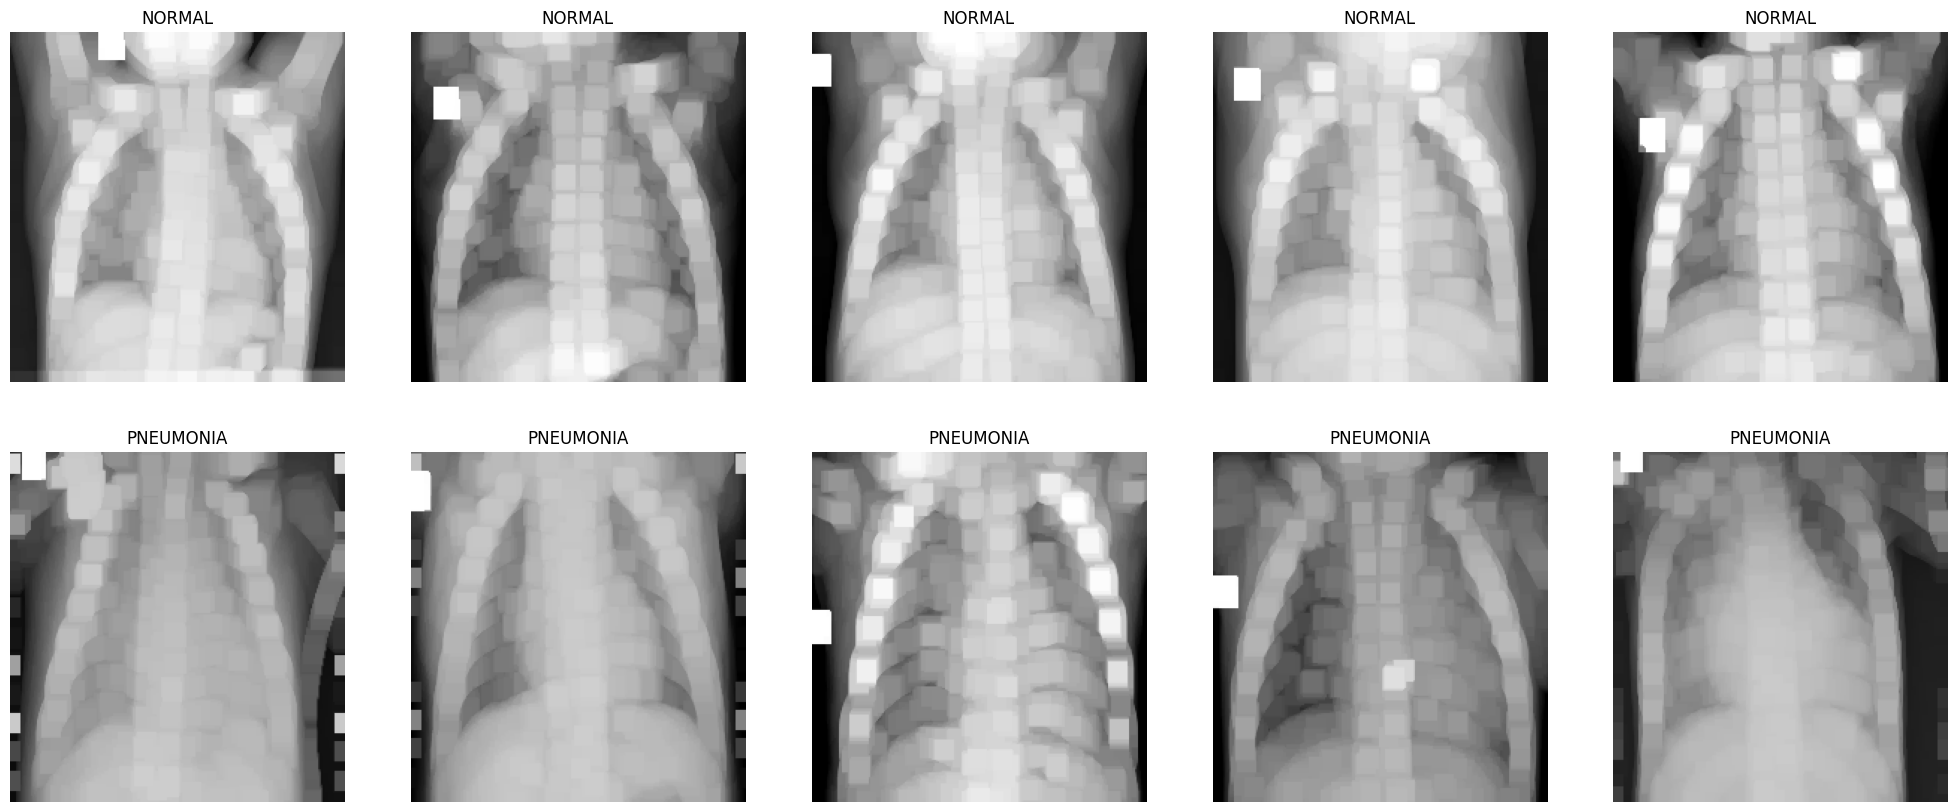

In [10]:
# Dilation Overview for train dataset
plotFiltImg(train,5,3)

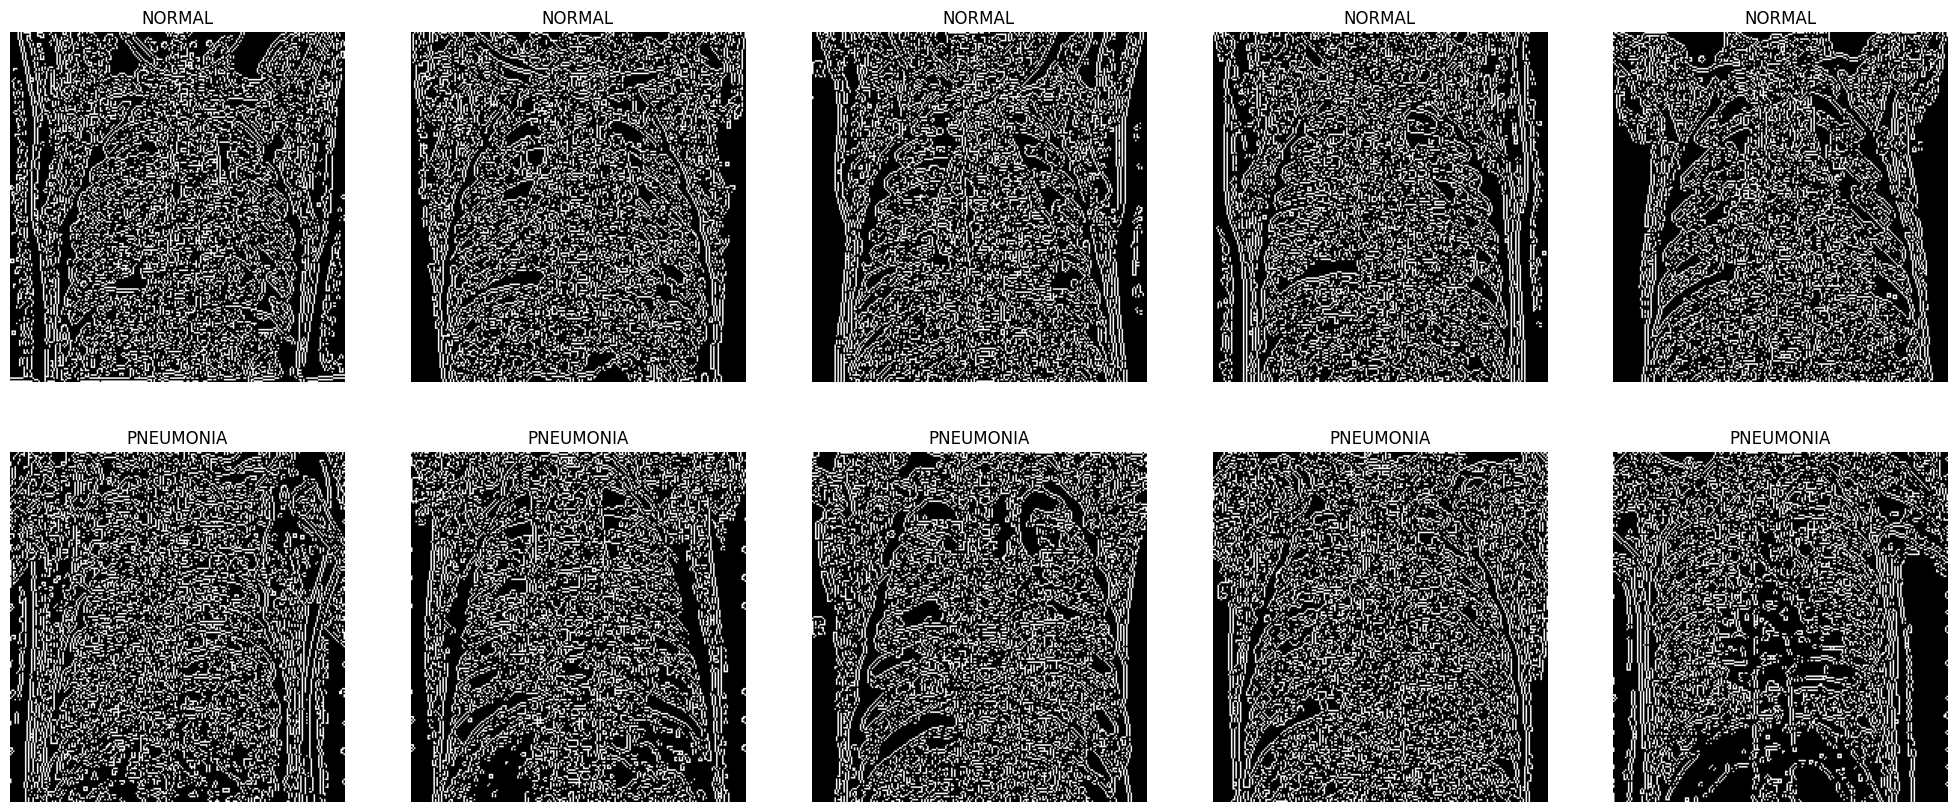

In [11]:
# All 3 filters Overview for train dataset
plotFiltImg(train,5,4)

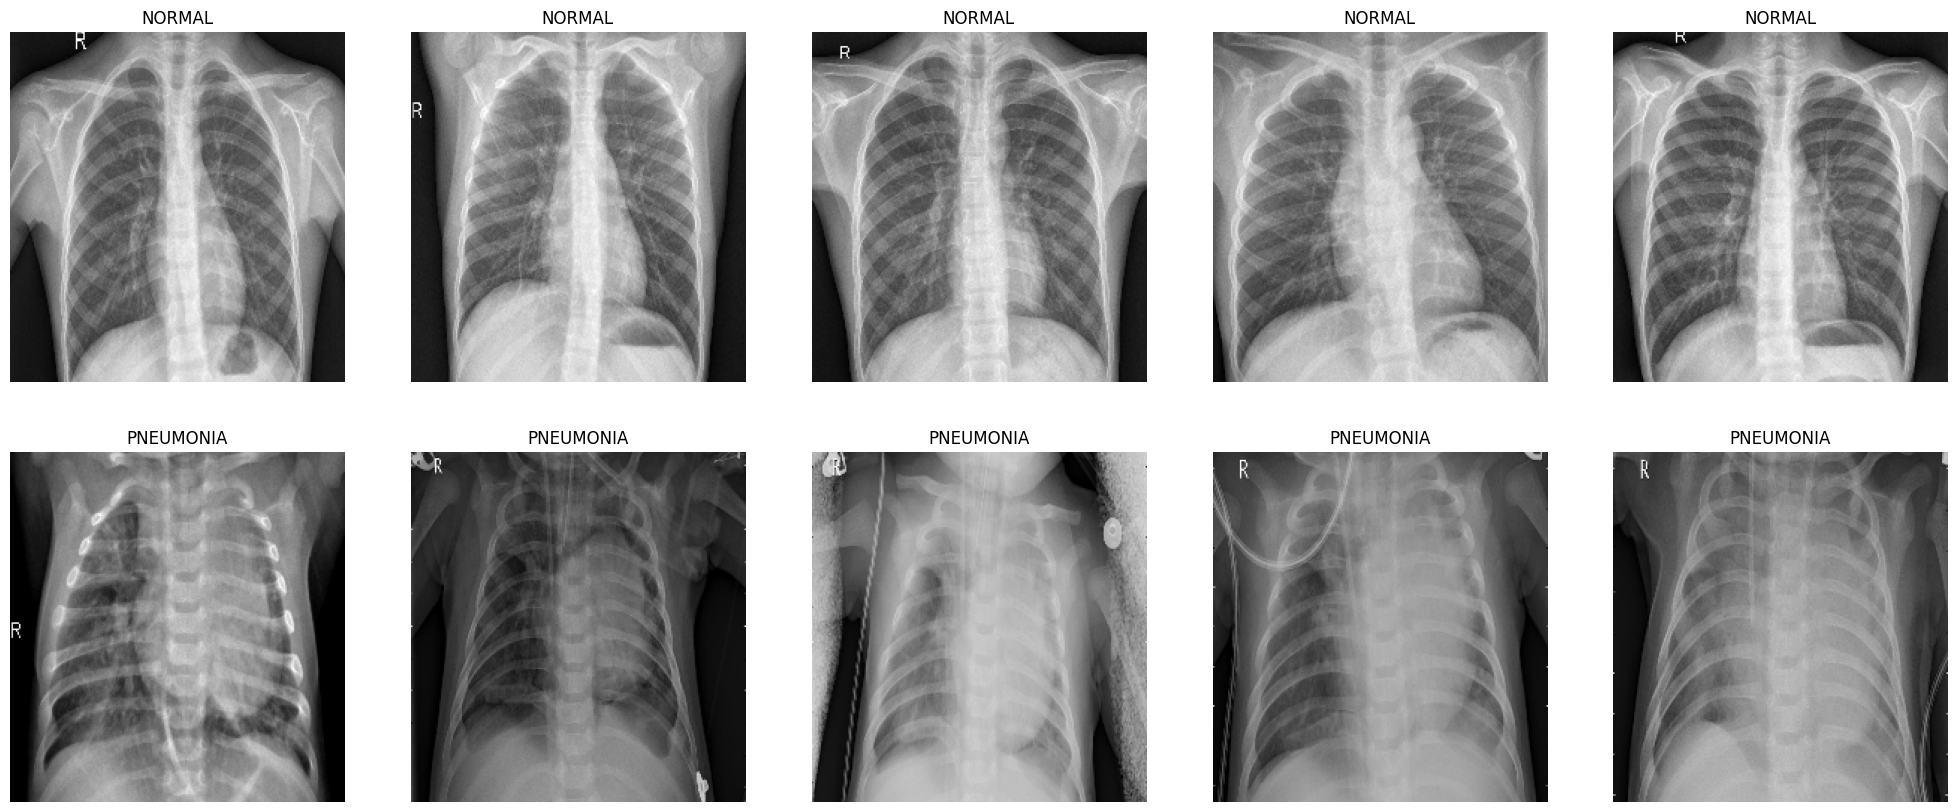

In [12]:
# Unfiltered Overview for test dataset
plotFiltImg(test,5)

## Loading data and pre-process images

In [13]:
# Define the image height and weight size for preprocessing
imageH= 224
imageW= 224

# Define the batch size for data loading and processing
batchSize = 32

# Define a seed value for randomization or reproducibility
randomSeed = 42

# Get a list of file paths for normal images in the training set
trainN = glob.glob(os.path.join(trainDir, "NORMAL", "*.jpeg"))

# Get a list of file paths for pneumonia images in the training set
trainP = glob.glob(os.path.join(trainDir, "PNEUMONIA", "*.jpeg"))

# Get a list of file paths for normal images in the testing set
testN = glob.glob(os.path.join(testDir, "NORMAL", "*.jpeg"))

# Get a list of file paths for pneumonia images in the testing set
testP = glob.glob(os.path.join(testDir, "PNEUMONIA", "*.jpeg"))

# Get a list of file paths for normal images in the validation set
valN = glob.glob(os.path.join(valDir, "NORMAL", "*.jpeg"))

# Get a list of file paths for pneumonia images in the validation set
valP = glob.glob(os.path.join(valDir, "PNEUMONIA", "*.jpeg"))

# Create a list of file paths for training data, combining normal and pneumonia images
trainList = [x for x in trainN]
trainList.extend([x for x in trainP])

# Create a dataframe for the training dataset, specifying the 'class' and 'image' columns
trainDF = pd.DataFrame(
    np.concatenate([['Normal'] * len(trainN), ['Pneumonia'] * len(trainP)]),
    columns=['class']
)
trainDF['image'] = [x for x in trainList]

# Create a list of file paths for testing data, combining normal and pneumonia images
testList = [x for x in testN]
testList.extend([x for x in testP])

# Create a dataframe for the testing dataset, specifying the 'class' and 'image' columns
testDF = pd.DataFrame(
    np.concatenate([['Normal'] * len(testN), ['Pneumonia'] * len(testP)]),
    columns=['class']
)
testDF['image'] = [x for x in testList]

# Create a list of file paths for testing data, combining normal and pneumonia images
valList = [x for x in valN]
valList.extend([x for x in valP])

# Create a dataframe for the testing dataset, specifying the 'class' and 'image' columns
valDF = pd.DataFrame(
    np.concatenate([['Normal'] * len(valN), ['Pneumonia'] * len(valP)]),
    columns=['class']
)
valDF['image'] = [x for x in valList]

# Create an ImageDataGenerator for data augmentation and preprocessing in the training dataset
trainDG = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values to the range [0, 1]
    rotation_range=10,             # Rotate by a certain degree range to simulate different angles at which X-rays might be taken
    brightness_range=[0.8, 1.2],   # Adjust brightness 
    zoom_range=0.1,                # Apply random zoom transformations
    width_shift_range=0.1,         # Apply random horizontal shifts
    height_shift_range=0.1         # Apply random vertical shifts
)

# Create an ImageDataGenerator for preprocessing in the validation and testing datasets
valTestDG = ImageDataGenerator(rescale=1./255)

# Create a data generator for the training dataset
trainDS = trainDG.flow_from_dataframe(
    trainDF,                     # Dataframe containing image paths and class labels
    x_col='image',                # Column containing image file paths
    y_col='class',                # Column containing class labels
    target_size=(imageH, imageW),  # Resize images to a specific size
    class_mode='binary',          # Binary classification (two classes)
    batch_size=batchSize,             # Batch size for training
    seed=randomSeed                     # Random seed for reproducibility
)

# Create a data generator for the testing dataset
testDS = valTestDG.flow_from_dataframe(
    testDF,                      # Dataframe containing image paths and class labels
    x_col='image',                # Column containing image file paths
    y_col='class',                # Column containing class labels
    target_size=(imageH, imageW),  # Resize images to a specific size
    class_mode='binary',          # Binary classification (two classes)
    batch_size=1,                 # Batch size for testing (set to 1 for individual predictions)
    shuffle=False                 # Do not shuffle the testing data
)

# Create a data generator for the validation dataset
valDS = valTestDG.flow_from_dataframe(
    valDF,                       # Dataframe containing image paths and class labels
    x_col='image',                # Column containing image file paths
    y_col='class',                # Column containing class labels
    target_size=(imageH, imageW),  # Resize images to a specific size
    class_mode='binary',          # Binary classification (two classes)
    batch_size=batchSize,             # Batch size for validation
    seed=randomSeed                     # Random seed for reproducibility
)

Found 5216 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


In [14]:
#print trainDF
trainDF

class                                                image
0        Normal            chest_xray\train\NORMAL\IM-0115-0001.jpeg
1        Normal            chest_xray\train\NORMAL\IM-0117-0001.jpeg
2        Normal            chest_xray\train\NORMAL\IM-0119-0001.jpeg
3        Normal            chest_xray\train\NORMAL\IM-0122-0001.jpeg
4        Normal            chest_xray\train\NORMAL\IM-0125-0001.jpeg
...         ...                                                  ...
5211  Pneumonia   chest_xray\train\PNEUMONIA\person99_virus_183.jpeg
5212  Pneumonia  chest_xray\train\PNEUMONIA\person9_bacteria_38.jpeg
5213  Pneumonia  chest_xray\train\PNEUMONIA\person9_bacteria_39.jpeg
5214  Pneumonia  chest_xray\train\PNEUMONIA\person9_bacteria_40.jpeg
5215  Pneumonia  chest_xray\train\PNEUMONIA\person9_bacteria_41.jpeg

[5216 rows x 2 columns]

In [15]:
#print testDF
testDF

class                                                 image
0       Normal              chest_xray\test\NORMAL\IM-0001-0001.jpeg
1       Normal              chest_xray\test\NORMAL\IM-0003-0001.jpeg
2       Normal              chest_xray\test\NORMAL\IM-0005-0001.jpeg
3       Normal              chest_xray\test\NORMAL\IM-0006-0001.jpeg
4       Normal              chest_xray\test\NORMAL\IM-0007-0001.jpeg
..         ...                                                   ...
619  Pneumonia  chest_xray\test\PNEUMONIA\person96_bacteria_465.jpeg
620  Pneumonia  chest_xray\test\PNEUMONIA\person96_bacteria_466.jpeg
621  Pneumonia  chest_xray\test\PNEUMONIA\person97_bacteria_468.jpeg
622  Pneumonia  chest_xray\test\PNEUMONIA\person99_bacteria_473.jpeg
623  Pneumonia  chest_xray\test\PNEUMONIA\person99_bacteria_474.jpeg

[624 rows x 2 columns]

## Callbacks for training models

In [16]:
# Define an EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor for early stopping (validation loss)
    patience=5,                    # Number of epochs with no improvement before stopping
    min_delta=1e-7,                # Minimum change in monitored metric to be considered an improvement
    verbose=1,                     # Verbosity level (1 for updates)
    restore_best_weights=True,     # Restore model weights to the best state when stopped
)

# Define a ReduceLROnPlateau callback
plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',            # Metric to monitor for learning rate reduction (validation loss)
    factor=0.5,                    # Factor by which the learning rate will be reduced (e.g., 0.2 means lr *= 0.2)
    patience=2,                    # Number of epochs with no improvement before reducing the learning rate
    min_delta=1e-6,                # Minimum change in monitored metric to trigger a reduction
    cooldown=0,                    # Number of epochs to wait after a reduction before resuming normal operation
    verbose=1                      # Verbosity level (1 for updates)
)

## Baseline Model (CNN)

In [17]:
def baselineCNNModel():
  # Input layer
  inputs = Input(shape=(imageH, imageW, 3))

  # Convolutional layers
  x = Conv2D(32, (3, 3), activation='relu')(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D((2, 2))(x)

  # Flatten layer
  x = Flatten()(x)

  # Fully connected layers
  x = Dense(64, activation='relu')(x)
  output = Dense(1, activation='sigmoid')(x) 

  # Create model
  model = Model(inputs=[inputs], outputs=output)

  return model

# Clear the Keras session to release resources
keras.backend.clear_session()

# Create a CNN model using the defined 'baseline_model' function
baselineCNN = baselineCNNModel()

# Compile the CNN model with specified loss, optimizer, and metrics
baselineCNN.compile(
    loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
    optimizer=keras.optimizers.Adam(),  # Adam optimizer with a custom learning rate
    metrics=['binary_accuracy']  # Metric to monitor during training (binary accuracy)
)

# Display a summary of the model architecture
baselineCNN.summary()

# Train the model
bCNNHist = baselineCNN.fit(trainDS,
          validation_data=valDS,
          epochs=10,
          batch_size=batchSize,
          callbacks=[early_stopping,plateau]  #  Callbacks for early stopping and learning rate reduction
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,457 (45.64 MB)

 Trainable params: 11,963,457 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 164s 969ms/step - binary_accuracy: 0.7681 - loss: 0.5633 - val_binary_accuracy: 0.6250 - val_loss: 0.8222 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 962ms/step - binary_accuracy: 0.9060 - loss: 0.2224 - val_binary_accuracy: 0.6875 - val_loss: 0.6597 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 162s 964ms/step - binary_accuracy: 0.9265 - loss: 0.1917 - val_binary_accuracy: 0.6250 - val_loss: 0.7158 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 162s 962ms/step - binary_accuracy: 0.9226 - loss: 0.2025 - val_binary_accuracy: 0.7500 - val_loss: 0.2978 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 962ms/step - binary_accuracy: 0.9225 - loss: 0.1948 - val_binary_accuracy: 0.6250 - val_loss: 0.9377 - learning_rate: 0.0010
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - binary_accuracy: 0.9294 - loss: 0.1853
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.

In [19]:
# Evaluate the CNN model on the validation dataset
valScoreCNN = baselineCNN.evaluate(valDS, steps=int(len(valDF)/batchSize), verbose=0)

# Print the validation loss and accuracy
print('Validation loss:', valScoreCNN[0])
print('Validation accuracy:', valScoreCNN[1])

# Evaluate the CNN model on the test dataset
testScoreCNN = baselineCNN.evaluate(testDS, steps=len(testDF), verbose=0)

# Print the test loss and accuracy
print('Test loss:', testScoreCNN[0])
print('Test accuracy:', testScoreCNN[1])


Validation loss: 0.12851378321647644
Validation accuracy: 1.0
Test loss: 0.3826754093170166
Test accuracy: 0.8862179517745972


In [73]:
# Evaluate the model on the test set and obtain predictions
testPredCNN = baselineCNN.predict(testDS, steps=len(testDF))

# Convert probability scores to binary predictions (0 or 1)
testProbPredCNN = (testPredCNN > 0.5).astype(int)

# Generate a classification report for precision, recall, and F1-score
testClassRptCNN = classification_report(testDS.labels, testProbPredCNN, output_dict=True)

# Print the test accuracy, precision, recall, and F1-score
print('Test Accuracy:', testClassRptCNN['accuracy'])
print('Test Precision (Overall):', testClassRptCNN['macro avg']['precision'])
print('Test Recall (Overall):', testClassRptCNN['macro avg']['recall'])
print('Test F1 Score (Overall):', testClassRptCNN['macro avg']['f1-score'])

624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step
Test Accuracy: 0.8862179487179487
Test Precision (Overall): 0.8891146166831596
Test Recall (Overall): 0.8662393162393163
Test F1 Score (Overall): 0.8752530613738945


## ResNet50 Model

In [21]:
def convBlock(x, filters, stage, block, stride=2):
    """
    Implementation of the convolutional block
    Arguments:
    x -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    stride -- Integer, specifying the stride to be used
    Returns:
    x -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    convName = 'convS' + str(stage) + 'B' + str(block) + 'P'
    bnName = 'bnS' + str(stage) + 'B' + str(block) + 'P'

    f1, f2, f3 = filters

    xCopy = x

    # First component of main path
    x = Conv2D(f1, (1, 1), strides=(stride, stride), name=convName + '2a')(x)
    x = BatchNormalization(axis=3, name=bnName + '2a')(x)
    x = Activation('relu')(x)

    # Second component of main path
    x = Conv2D(f2, (3, 3), strides=(1, 1), padding='same', name=convName + '2b')(x)
    x = BatchNormalization(axis=3, name=bnName + '2b')(x)
    x = Activation('relu')(x)

    # Third component of main path
    x = Conv2D(f3, (1, 1), strides=(1, 1), name=convName + '2c')(x)
    x = BatchNormalization(axis=3, name=bnName + '2c')(x)

    # Shortcut path
    # Conv2D to make shape the same size
    xCopy = Conv2D(f3, (1, 1), strides=(stride, stride), name=convName + '1')(xCopy)
    xCopy = BatchNormalization(axis=3, name=bnName + '1')(xCopy)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    x = Add()([x, xCopy])
    x = Activation('relu')(x)

    return x

def idBlock(x, filters, stage, block):
    """
    Implementation of the identity block
    Arguments:
    x -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    Returns:
    x -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    convName = 'convS' + str(stage) + 'B' + str(block) + 'P'
    bnName = 'bnS' + str(stage) + 'B' + str(block) + 'P'

    f1, f2, f3 = filters

    xCopy = x

    # First component of main path
    x = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=convName + '2a')(x)
    x = BatchNormalization(axis=3, name=bnName + '2a')(x)
    x = Activation('relu')(x)

    # Second component of main path
    x = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same', name=convName + '2b')(x)
    x = BatchNormalization(axis=3, name=bnName + '2b')(x)
    x = Activation('relu')(x)

    # Third component of main path
    x = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=convName + '2c')(x)
    x = BatchNormalization(axis=3, name=bnName + '2c')(x)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    x = Add()([x, xCopy])
    x = Activation('relu')(x)

    return x

def resnet50Model():
  inputs = Input(shape=(imageH, imageW, 3), name='input')
  # x = imageAug(inputs)

  # conv1 - Stage 1, Block 1
  x = Conv2D(filters=64, kernel_size=7, padding='same', strides=2, name="res1")(inputs)
  x = BatchNormalization(axis=3, name="bn1")(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size=3, padding='same', strides=2)(x)

  # conv2 - Stage 2, Block 2-4
  x = convBlock(x, filters=[64, 64, 256], stage=2, block=2, stride=1)
  x = idBlock(x, filters=[64, 64, 256], stage=2, block=3)
  x = idBlock(x, filters=[64, 64, 256], stage=2, block=4)

  # conv3 - Stage 3, Block 5-8
  x = convBlock(x, filters=[128, 128, 512], stage=3, block=5, stride=2)
  x = idBlock(x, filters=[128, 128, 512], stage=3, block=6)
  x = idBlock(x, filters=[128, 128, 512], stage=3, block=7)
  x = idBlock(x, filters=[128, 128, 512], stage=3, block=8)

  # conv4 - Stage 4, Block 9-14
  x = convBlock(x, filters=[256, 256, 1024], stage=4, block=9, stride=2)
  x = idBlock(x, filters=[256, 256, 1024], stage=4, block=10)
  x = idBlock(x, filters=[256, 256, 1024], stage=4, block=11)
  x = idBlock(x, filters=[256, 256, 1024], stage=4, block=12)
  x = idBlock(x, filters=[256, 256, 1024], stage=4, block=13)
  x = idBlock(x, filters=[256, 256, 1024], stage=4, block=14)

  # conv5 - Stage 5, Block 15-17
  x = convBlock(x, filters=[512, 512, 2048], stage=5, block=15, stride=2)
  x = idBlock(x, filters=[512, 512, 2048], stage=5, block=16)
  x = idBlock(x, filters=[512, 512, 2048], stage=5, block=17)

  # Block 18
  x = AveragePooling2D(pool_size=7, padding='same')(x)
  x = Dropout(0.1)(x) # To be adjusted as needed
  x = Flatten()(x)

  # Add fully connected layers
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.1)(x)  # To be adjusted as needed
  x = Dense(256, activation='relu')(x)

  output = Dense(1, activation='sigmoid')(x)

  # Create the model with defined inputs and outputs
  model = keras.Model(inputs=[inputs], outputs=output)

  return model


In [46]:
# @title
# Clear the Keras session to release resources
keras.backend.clear_session()

# Create a CNN model using the defined 'baseline_model' function
resNetModel = resnet50Model()

# Compile the CNN model with specified loss, optimizer, and metrics
resNetModel.compile(
    loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
    optimizer=keras.optimizers.Adam(),  # Adam optimizer with a custom learning rate
    metrics=['binary_accuracy']  # Metric to monitor during training (binary accuracy)
)

# Define an EarlyStopping callback
early_stopping2 = callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor for early stopping (validation loss)
    patience=5,                    # Number of epochs with no improvement before stopping
    min_delta=1e-7,                # Minimum change in monitored metric to be considered an improvement
    verbose=1,                     # Verbosity level (1 for updates)
    restore_best_weights=True,     # Restore model weights to the best state when stopped
)

# Define a ReduceLROnPlateau callback
plateau2 = callbacks.ReduceLROnPlateau(
    monitor='val_loss',            # Metric to monitor for learning rate reduction (validation loss)
    factor=0.8,                    # Factor by which the learning rate will be reduced (e.g., 0.2 means lr *= 0.2)
    patience=1,                    # Number of epochs with no improvement before reducing the learning rate
    min_delta=1e-6,                # Minimum change in monitored metric to trigger a reduction
    cooldown=0,                    # Number of epochs to wait after a reduction before resuming normal operation
    verbose=1                      # Verbosity level (1 for updates)
)

# Train the ResNet50 model using the training and validation datasets
resnet50History = resNetModel.fit(
    trainDS,                            # Training dataset
    batch_size=batchSize,                    # Batch size
    epochs=10,                           # Number of training epochs
    validation_data=valDS,              # Validation dataset
    callbacks=[early_stopping2 ,plateau2]  #  Callbacks for early stopping and learning rate reduction
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 857s 5s/step - binary_accuracy: 0.7842 - loss: 0.5483 - val_binary_accuracy: 0.5000 - val_loss: 13.6565 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 898s 5s/step - binary_accuracy: 0.9072 - loss: 0.2393 - val_binary_accuracy: 0.5625 - val_loss: 5.4593 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 901s 5s/step - binary_accuracy: 0.9304 - loss: 0.1842 - val_binary_accuracy: 0.5000 - val_loss: 1.9811 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9320 - loss: 0.1801
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
163/163 ━━━━━━━━━━━━━━━━━━━━ 896s 5s/step - binary_accuracy: 0.9320 - loss: 0.1800 - val_binary_accuracy: 0.5000 - val_loss: 2.8755 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9413 - loss: 0.1536
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
163/163

In [81]:
# Display a summary of the model architecture
resNetModel.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1 (Conv2D)       │ (None, 112, 112,  │      9,472 │ input[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 112, 112,  │        256 │ res1[0][0]        │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ bn1[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convS2B2P2a         │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bnS2B2P2a           │ (None, 56, 56,    │        256 │ convS2B2P2a[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ bnS2B2P2a[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convS2B2P2b         │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bnS2B2P2b           │ (None, 56, 56,    │        256 │ convS2B2P2b[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ bnS2B2P2b[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convS2B2P2c         │ (None, 56, 56,    │     16,640 │ activation_2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convS2B2P1 (Conv2D) │ (None, 56, 56,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bnS2B2P2c           │ (None, 56, 56,    │      1,024 │ convS2B2P2c[0][0] │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bnS2B2P1            │ (None, 56, 56,    │      1,024 │ convS2B2P1[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ bnS2B2P2c[0][0],  │
│                     │ 256)              │            │ bnS2B2P1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ add[0][0]       

 Total params: 74,198,917 (283.05 MB)

 Trainable params: 24,715,265 (94.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 49,430,532 (188.56 MB)

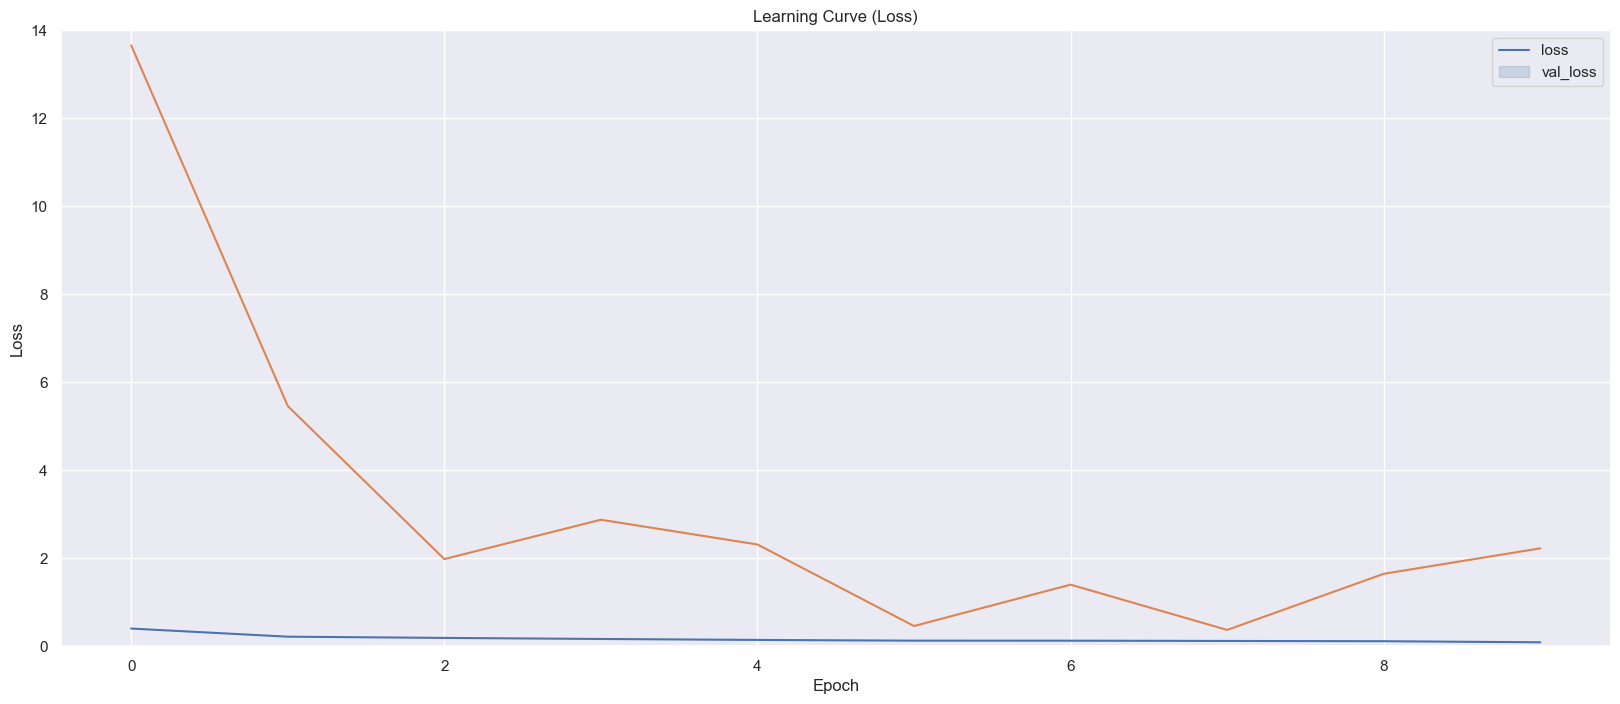

In [50]:
# Create a subplot with a specified figure size
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the training loss (x-axis: epoch, y-axis: loss)
sns.lineplot(x=resnet50History.epoch, y=resnet50History.history['loss'])

# Plot the validation loss (x-axis: epoch, y-axis: loss)
sns.lineplot(x=resnet50History.epoch, y=resnet50History.history['val_loss'])

# Set the title of the plot
ax.set_title('Learning Curve (Loss)')

# Set the label for the y-axis
ax.set_ylabel('Loss')

# Set the label for the x-axis
ax.set_xlabel('Epoch')

# Set the y-axis limit for the loss values
ax.set_ylim(0, 14)

# Add a legend to differentiate between training and validation loss
ax.legend(['loss', 'val_loss'], loc='best')

# Display the plot
plt.show()

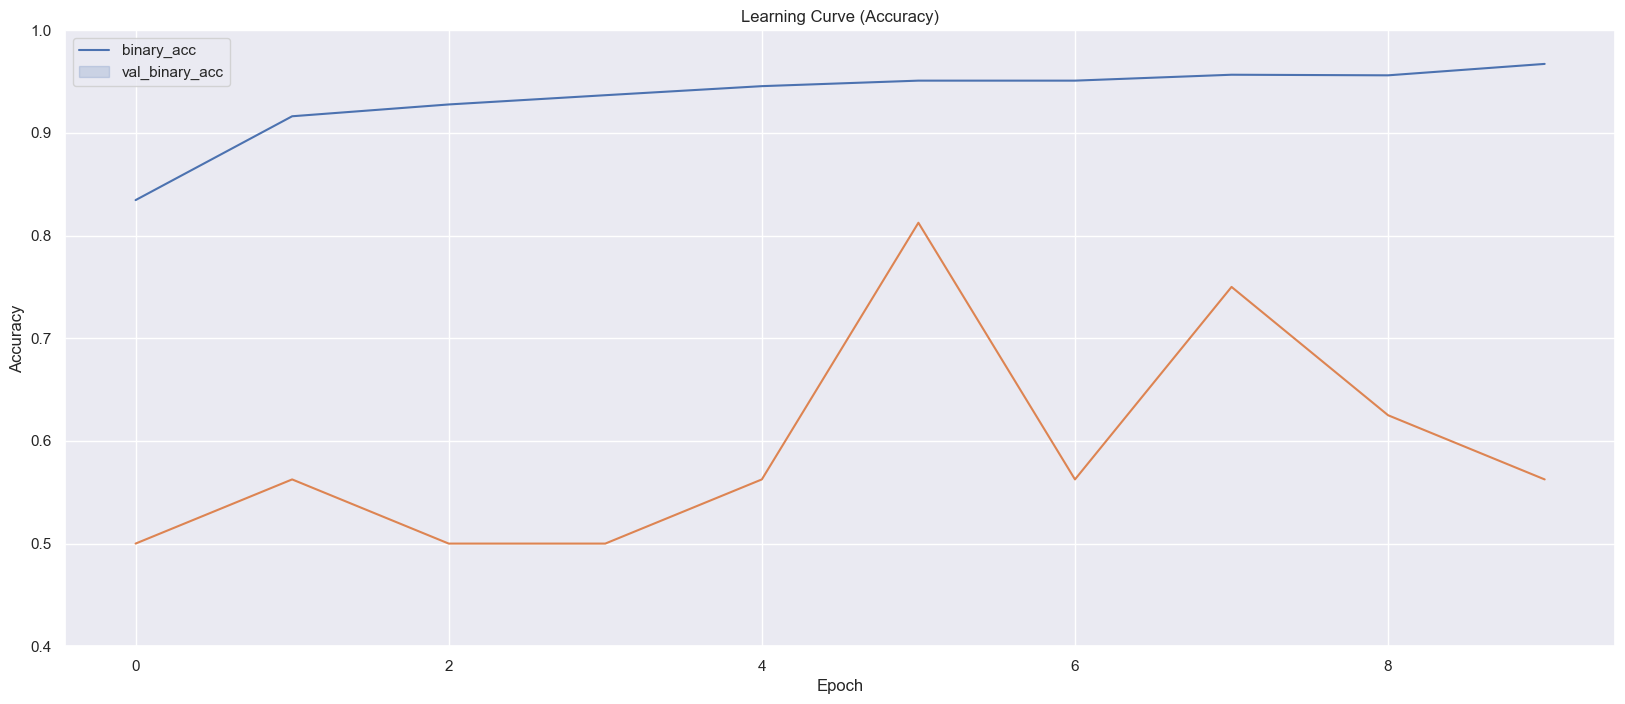

In [48]:
# Create a subplot with a specified figure size
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the training accuracy (x-axis: epoch, y-axis: accuracy)
sns.lineplot(x=resnet50History.epoch, y=resnet50History.history['binary_accuracy'])

# Plot the validation accuracy (x-axis: epoch, y-axis: accuracy)
sns.lineplot(x=resnet50History.epoch, y=resnet50History.history['val_binary_accuracy'])

# Set the title of the plot
ax.set_title('Learning Curve (Accuracy)')

# Set the label for the y-axis
ax.set_ylabel('Accuracy')

# Set the label for the x-axis
ax.set_xlabel('Epoch')

# Set the y-axis limit for the accuracy values
ax.set_ylim(0.40, 1.0)

# Add a legend to differentiate between training and validation accuracy
ax.legend(['binary_acc', 'val_binary_acc'], loc='best')

# Display the plot
plt.show()

In [49]:
# Use the evaluate method to obtain the validation loss and accuracy
resNetScore = resNetModel.evaluate(valDS, steps= int(len(valDF)/batchSize), verbose=0)

# Print the validation loss and accuracy
print('Validation Loss:', resNetScore[0])
print('Validation Accuracy:', resNetScore[1])

# Use the evaluate method to obtain the test loss and accuracy
resNetScore2 = resNetModel.evaluate(testDS, steps=len(testDF), verbose=0)

# Print the test loss and accuracy
print('Test Loss:', resNetScore2[0])
print('Test Accuracy:', resNetScore2[1])

Validation Loss: 0.3705666661262512
Validation Accuracy: 0.75
Test Loss: 0.27536845207214355
Test Accuracy: 0.8894230723381042


In [68]:
# Evaluate the model on the test set and obtain predictions
testPredRN = resNetModel.predict(testDS, steps=len(testDF))

# Convert probability scores to binary predictions (0 or 1)
testProbPredRN = (testPredRN > 0.5).astype(int)

# Generate a classification report for precision, recall, and F1-score
testClassRptRN = classification_report(testDS.labels, testProbPredRN, output_dict=True)

# Print the test accuracy, precision, recall, and F1-score
print('Test Accuracy:', testClassRptRN['accuracy'])
print('Test Precision (Overall):', testClassRptRN['macro avg']['precision'])
print('Test Recall (Overall):', testClassRptRN['macro avg']['recall'])
print('Test F1 Score (Overall):', testClassRptRN['macro avg']['f1-score'])


624/624 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step
Test Accuracy: 0.8894230769230769
Test Precision (Overall): 0.9027367268746579
Test Recall (Overall): 0.8628205128205129
Test F1 Score (Overall): 0.8766215344938749


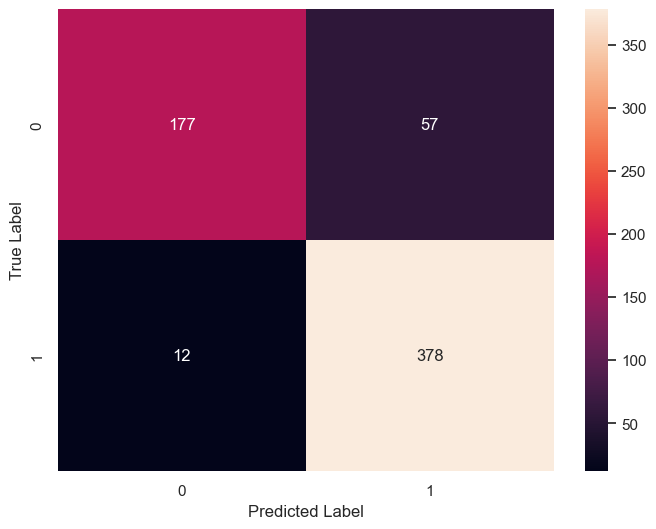

In [69]:
# Calculate the confusion matrix between true labels and predicted labels
confMatRN = metrics.confusion_matrix(testDS.labels, testProbPredRN)

# Create a heatmap of the confusion matrix with annotations
sns.heatmap(confMatRN, annot=True, fmt="d")

# Set the x-axis label
plt.xlabel("Predicted Label", fontsize=12)

# Set the y-axis label
plt.ylabel("True Label", fontsize=12)

# Display the heatmap
plt.show()

## Stacked multi-model of MobileNet and multiple DenseNet variants

In [27]:

# Load pre-trained models
baseMmobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
baseMdensenet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
baseMdensenet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
baseMdensenet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in baseMmobilenet.layers:
    layer.trainable = False
for layer in baseMdensenet121.layers:
    layer.trainable = False
for layer in baseMdensenet169.layers:
    layer.trainable = False
for layer in baseMdensenet201.layers:
    layer.trainable = False

# Define input tensor
input_tensor = Input(shape=(224, 224, 3))

# Extract features using global average pooling layer
mobilenetOut = baseMmobilenet(input_tensor)
mobilenetOut = GlobalAveragePooling2D()(mobilenetOut)

densenet121Out = baseMdensenet121(input_tensor)
densenet121Out = GlobalAveragePooling2D()(densenet121Out)

densenet169Out = baseMdensenet169(input_tensor)
densenet169Out = GlobalAveragePooling2D()(densenet169Out)

densenet201Out = baseMdensenet201(input_tensor)
densenet201Out = GlobalAveragePooling2D()(densenet201Out)

# Concatenate features
concFeatures = Concatenate()([mobilenetOut, densenet121Out, densenet169Out, densenet201Out])

# Add a dense layer for final classification
output = Dense(512, activation='relu')(concFeatures)
output = Dense(1, activation='sigmoid')(output)

# Create model
stackedModel = Model(inputs=input_tensor, outputs=output)

# Compile model
stackedModel.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])

# Train the model
stackedModelHist = stackedModel.fit(
    trainDS,                               # Training dataset
    batch_size=batchSize,                  # Batch size
    epochs=10,                             # Number of training epochs
    validation_data=valDS,                 # Validation dataset
    callbacks=[early_stopping,plateau]   #  Callbacks for early stopping and learning rate reduction
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 701s 4s/step - binary_accuracy: 0.8810 - loss: 0.4850 - val_binary_accuracy: 1.0000 - val_loss: 0.1237 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 645s 4s/step - binary_accuracy: 0.9738 - loss: 0.0748 - val_binary_accuracy: 0.8750 - val_loss: 0.2061 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 652s 4s/step - binary_accuracy: 0.9682 - loss: 0.0801 - val_binary_accuracy: 1.0000 - val_loss: 0.1046 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 652s 4s/step - binary_accuracy: 0.9700 - loss: 0.0796 - val_binary_accuracy: 1.0000 - val_loss: 0.0496 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 649s 4s/step - binary_accuracy: 0.9768 - loss: 0.0581 - val_binary_accuracy: 1.0000 - val_loss: 0.0221 - learning_rate: 0.0010
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 650s 4s/step - binary_accuracy: 0.9784 - loss: 0.0635 - val_binary_accuracy: 1.0000 - val_loss: 0.0110 - learning_rate: 0.001

In [82]:
# Display a summary of the model architecture
stackedModel.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_1.00_224  │ (None, 7, 7,      │  3,228,864 │ input_layer_4[0]… │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet121         │ (None, 7, 7,      │  7,037,504 │ input_layer_4[0]… │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet169         │ (None, 7, 7,      │ 12,642,880 │ input_layer_4[0]… │
│ (Functional)        │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet201         │ (None, 7, 7,      │ 18,321,984 │ input_layer_4[0]… │
│ (Functional)        │ 1920)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ mobilenet_1.00_2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ densenet121[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ densenet169[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1920)      │          0 │ densenet201[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5632)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │  2,884,096 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │        513 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,885,061 (190.30 MB)

 Trainable params: 2,884,609 (11.00 MB)

 Non-trainable params: 41,231,232 (157.28 MB)

 Optimizer params: 5,769,220 (22.01 MB)

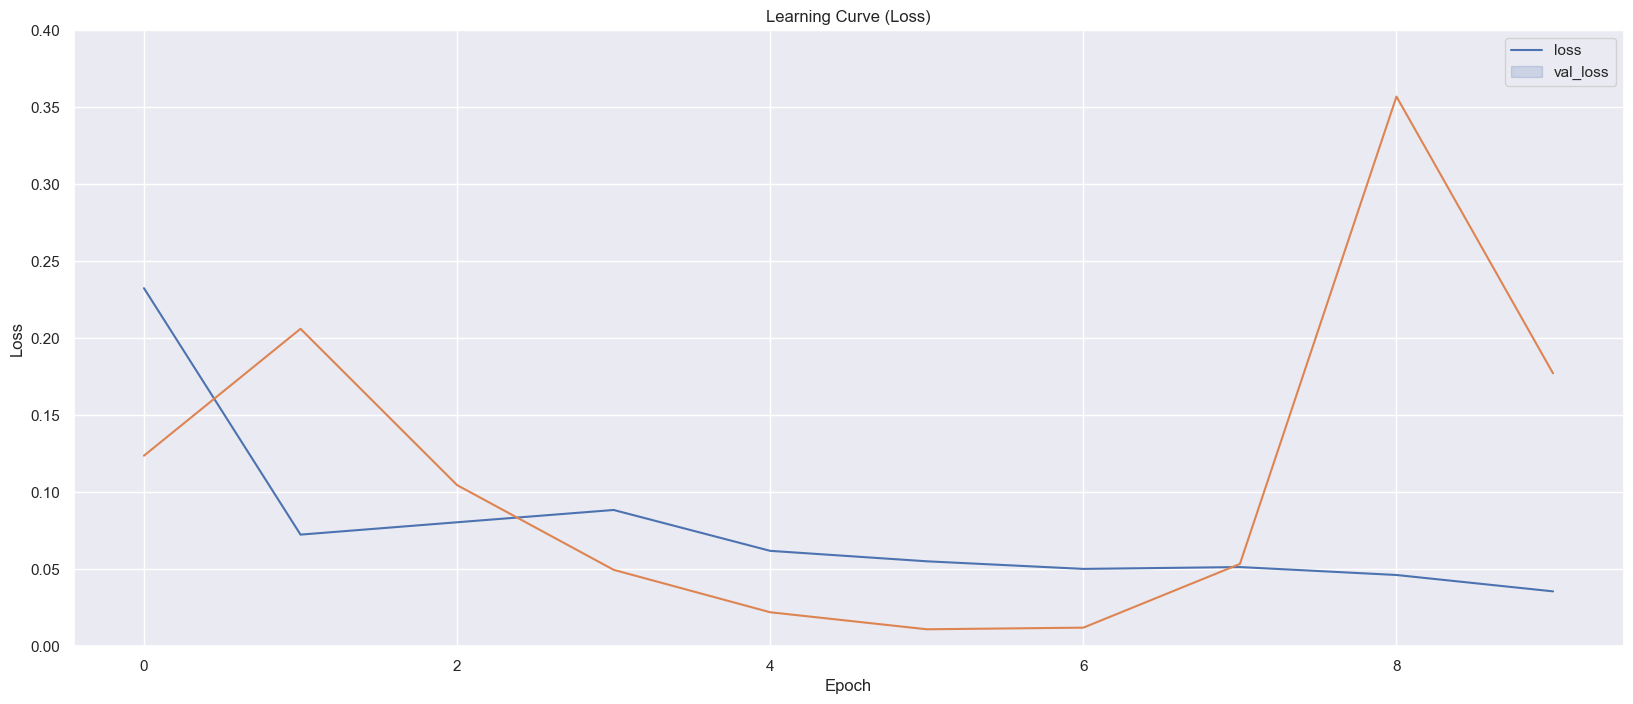

In [44]:
# Create a subplot with a specified figure size
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the training loss (x-axis: epoch, y-axis: loss)
sns.lineplot(x=stackedModelHist.epoch, y=stackedModelHist.history['loss'])

# Plot the validation loss (x-axis: epoch, y-axis: loss)
sns.lineplot(x=stackedModelHist.epoch, y=stackedModelHist.history['val_loss'])

# Set the title of the plot
ax.set_title('Learning Curve (Loss)')

# Set the label for the y-axis
ax.set_ylabel('Loss')

# Set the label for the x-axis
ax.set_xlabel('Epoch')

# Set the y-axis limit for the loss values
ax.set_ylim(0, 0.4)

# Add a legend to differentiate between training and validation loss
ax.legend(['loss', 'val_loss'], loc='best')

# Display the plot
plt.show()

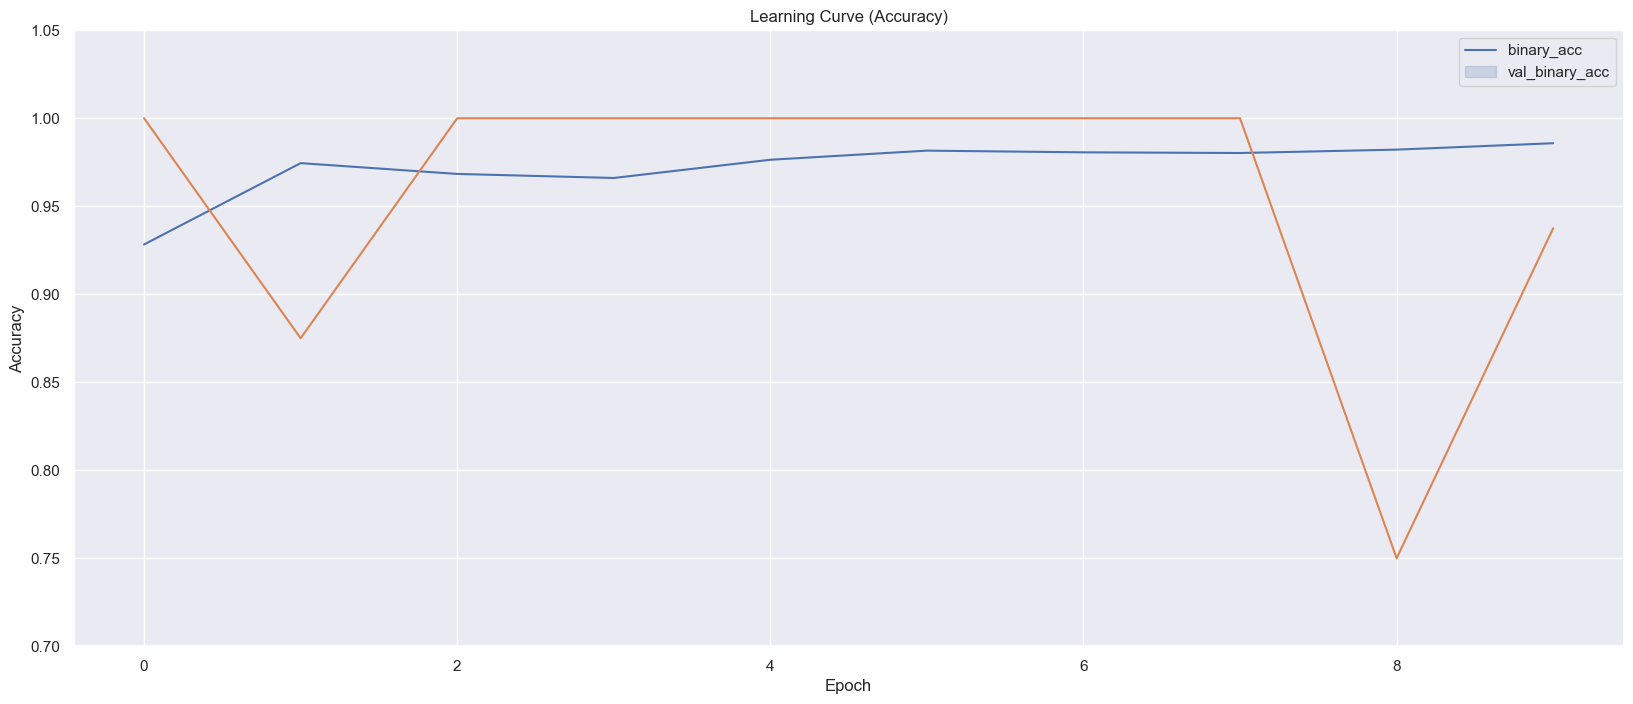

In [45]:
# Create a subplot with a specified figure size
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the training accuracy (x-axis: epoch, y-axis: accuracy)
sns.lineplot(x=stackedModelHist.epoch, y=stackedModelHist.history['binary_accuracy'])

# Plot the validation accuracy (x-axis: epoch, y-axis: accuracy)
sns.lineplot(x=stackedModelHist.epoch, y=stackedModelHist.history['val_binary_accuracy'])

# Set the title of the plot
ax.set_title('Learning Curve (Accuracy)')

# Set the label for the y-axis
ax.set_ylabel('Accuracy')

# Set the label for the x-axis
ax.set_xlabel('Epoch')

# Set the y-axis limit for the accuracy values
ax.set_ylim(0.7, 1.05)

# Add a legend to differentiate between training and validation accuracy
ax.legend(['binary_acc', 'val_binary_acc'], loc='best')

# Display the plot
plt.show()

In [30]:
# Use the evaluate method to obtain the validation loss and accuracy
StackedScore = stackedModel.evaluate(valDS, steps=int(len(valDF)/batchSize), verbose=0)

# Print the validation loss and accuracy
print('Validation Loss:', StackedScore[0])
print('Validation Accuracy:', StackedScore[1])

# Use the evaluate method to obtain the test loss and accuracy
StackedScore2 = stackedModel.evaluate(testDS, steps=len(testDF), verbose=0)

# Print the test loss and accuracy
print('Test Loss:', StackedScore2[0])
print('Test Accuracy:', StackedScore2[1])

Validation Loss: 0.011016316711902618
Validation Accuracy: 1.0
Test Loss: 0.22708022594451904
Test Accuracy: 0.9310897588729858


In [70]:
testPredStackedM = stackedModel.predict(testDS, steps=len(testDF))

# Convert probability scores to binary predictions (0 or 1)
testProbPredStackedM = (testPredStackedM > 0.5).astype(int)

# Generate a classification report for precision, recall, and F1-score
testClassRptStackedM = classification_report(testDS.labels, testProbPredStackedM, output_dict=True)

# Print the test accuracy, precision, recall, and F1-score
print('Test Accuracy:', testClassRptStackedM['accuracy'])
print('Test Precision (Overall):', testClassRptStackedM['macro avg']['precision'])
print('Test Recall (Overall):', testClassRptStackedM['macro avg']['recall'])
print('Test F1 Score (Overall):', testClassRptStackedM['macro avg']['f1-score'])


624/624 ━━━━━━━━━━━━━━━━━━━━ 196s 297ms/step
Test Accuracy: 0.9310897435897436
Test Precision (Overall): 0.9341957127423666
Test Recall (Overall): 0.9183760683760684
Test F1 Score (Overall): 0.9252071771228512


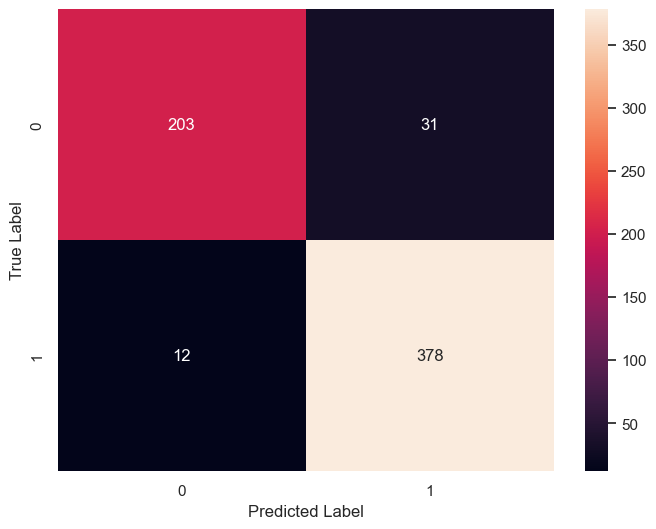

In [71]:
# Calculate the confusion matrix between true labels and predicted labels
confMatStackedM = metrics.confusion_matrix(testDS.labels, testProbPredStackedM)

# Create a heatmap of the confusion matrix with annotations
sns.heatmap(confMatStackedM, annot=True, fmt="d")

# Set the x-axis label
plt.xlabel("Predicted Label", fontsize=12)

# Set the y-axis label
plt.ylabel("True Label", fontsize=12)

# Display the heatmap
plt.show()

## Ensemble learning using averaging

In [78]:
# Define weights for each model
weights = [0.5, 0.5]

# Perform averaging of predictions
avgPred = ( weights[0]*testPredRN + weights[1]*testPredStackedM)

# Convert probability scores to binary predictions (0 or 1)
finalPred = (avgPred > 0.5).astype(int)

# Generate a classification report for precision, recall, and F1-score
testClassRptAM = classification_report(testDS.labels, finalPred, output_dict=True)

# Print the test accuracy, precision, recall, and F1-score
print('Test Accuracy:', testClassRptAM['accuracy'])
print('Test Precision (Overall):', testClassRptAM['macro avg']['precision'])
print('Test Recall (Overall):', testClassRptAM['macro avg']['recall'])
print('Test F1 Score (Overall):', testClassRptAM['macro avg']['f1-score'])

Test Accuracy: 0.9375
Test Precision (Overall): 0.9459389010530705
Test Recall (Overall): 0.9217948717948719
Test F1 Score (Overall): 0.9316187441519359


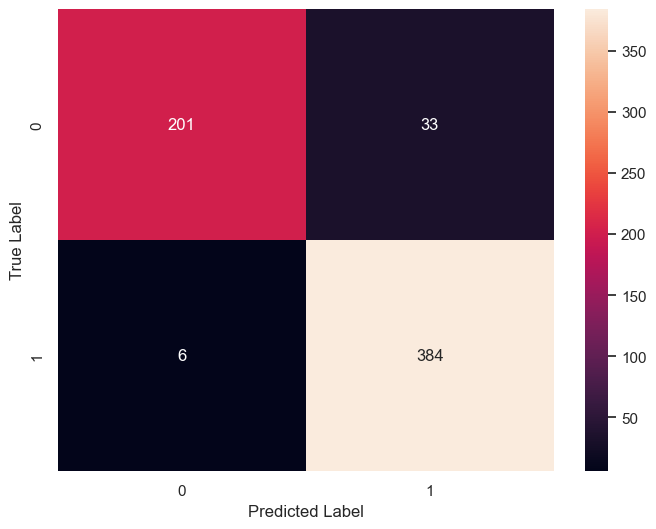

In [80]:
# Calculate the confusion matrix between true labels and predicted labels
confMatFinal = metrics.confusion_matrix(testDS.labels, finalPred)

# Create a heatmap of the confusion matrix with annotations
sns.heatmap(confMatFinal, annot=True, fmt="d")

# Set the x-axis label
plt.xlabel("Predicted Label", fontsize=12)

# Set the y-axis label
plt.ylabel("True Label", fontsize=12)

# Display the heatmap
plt.show()

## Compare each model to the ensembled model

In [76]:
# Define a dictionary with model accuracy scores
accScoreDict = {'ResNet': round(testClassRptRN['accuracy']*100,2), 
                'Stacked Transfer Learning': round(testClassRptStackedM['accuracy']*100,2), 
                'Ensembled Model': round(testClassRptAM['accuracy']*100,2),
                'Baseline CNN': round(testClassRptCNN['accuracy']*100,2)}

# Convert the dictionary into a Pandas Series
accScore = pd.Series(accScoreDict)

# Sort the models based on their accuracy scores and store the sorted order
order = accScore.sort_values()

order

Baseline CNN                 88.62
ResNet                       88.94
Stacked Transfer Learning    93.11
Ensembled Model              93.75
dtype: float64

Text(0.5, 1.0, 'Accuracy score of models')

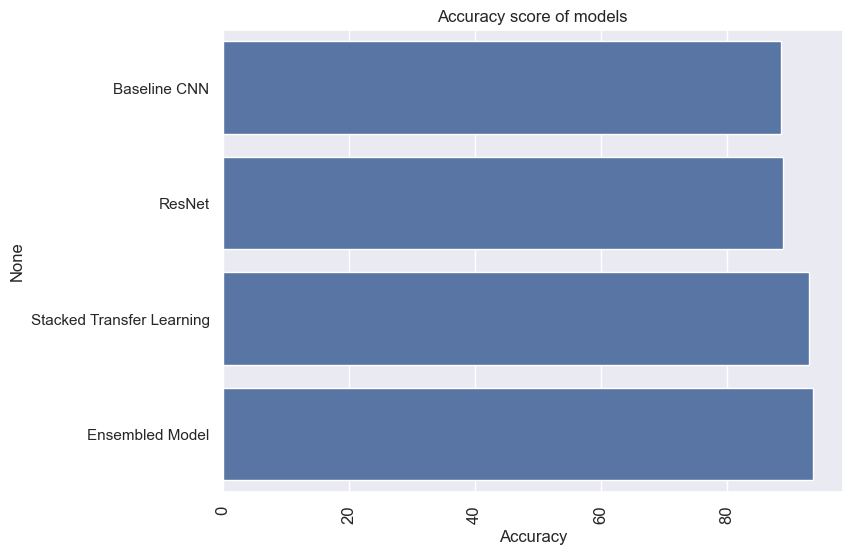

In [75]:
# Import necessary libraries
from matplotlib import pyplot
import seaborn as sns

# Set the figure size for the plot
sns.set(rc={'figure.figsize':(8,6)})

# Create a horizontal bar plot using Seaborn
sns.barplot(x=order.values, y=order.index, orient='h')

# Set labels and title for the plot
plt.xlabel('Accuracy')  # X-axis label
plt.xticks(rotation='vertical', fontsize=12)  # Rotate x-axis labels and set font size
plt.title('Accuracy score of models')  # Title of the plot

In [36]:
%pip freeze > requirements.txt